In [2]:
# Export an ONNX model from a PyTorch .pt model

import torch.onnx
# Loading the input PyTorch model and mapping the tensors to CPU
device = torch.device('cpu')
model = torch.load('animals_caltech.pt', map_location=device)

# Generate a dummy input that is consistent with the network's arhitecture
dummy_input = torch.randn(1, 3, 224, 224)

# Export into an ONNX model using the PyTorch model and the dummy input
torch.onnx.export(model, dummy_input, "animals_caltech.onnx")



/Users/snayak/anaconda3/envs/pytorch_inference1/lib/python3.7/site-packages/torch/serialization.py:454: SourceChangeWarning: source code of class 'torchvision.models.resnet.ResNet' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/Users/snayak/anaconda3/envs/pytorch_inference1/lib/python3.7/site-packages/torch/serialization.py:454: SourceChangeWarning: source code of class 'torchvision.models.resnet.Bottleneck' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


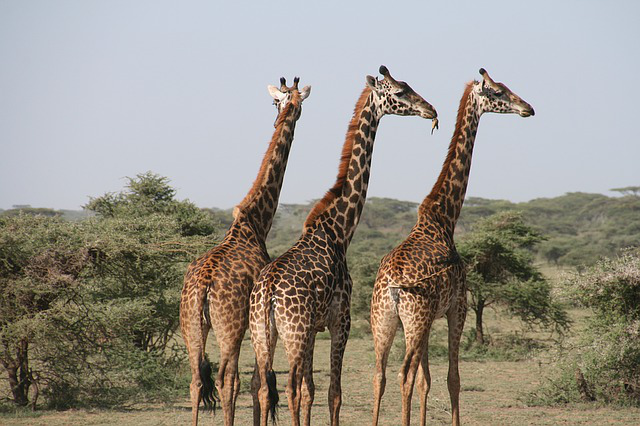

Local CPU Inference time in MacOS using ONNX model :  0.39600086212158203
Prediction  1 : giraffe     , Class Id :  2  Score:  0.99414057
Prediction  2 : ostrich     , Class Id :  5  Score:  0.0034540326
Prediction  3 : zebra       , Class Id :  9  Score:  0.0013424809
Prediction  4 : llama       , Class Id :  4  Score:  0.00086722267
Prediction  5 : bear        , Class Id :  0  Score:  7.583578e-05
Prediction  6 : triceratops , Class Id :  8  Score:  6.4069485e-05
Prediction  7 : porcupine   , Class Id :  6  Score:  1.9247791e-05
Prediction  8 : gorilla     , Class Id :  3  Score:  1.8487592e-05
Prediction  9 : chimp       , Class Id :  1  Score:  1.6452961e-05
Prediction 10 : skunk       , Class Id :  7  Score:  1.5678779e-06


In [3]:
# Inference in Caffe using the ONNX model

import caffe2.python.onnx.backend as backend
import onnx

from torchvision import transforms
from PIL import Image
import time
import numpy as np

# First load the onnx model
model = onnx.load("animals_caltech.onnx")

# Prepare the backend
rep = backend.prepare(model, device="CPU")

# Transform the image
transform = transforms.Compose([
        transforms.Resize(size=224),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])
          
# Load and show the image
test_image_name = "giraffe.jpg"
test_image = Image.open(test_image_name)
display(test_image)

# Apply the transformations to the input image and convert it into a tensor
test_image_tensor = transform(test_image)

# Make the input image ready to be input as a batch of size 1
test_image_tensor = test_image_tensor.view(1, 3, 224, 224)

time_start = time.time()
# Convert the tensor to numpy array
np_image = test_image_tensor.numpy()

# Pass the numpy array to run through the ONNX model
outputs = rep.run(np_image.astype(np.float32))
time_end = time.time()
print("Local CPU Inference time in MacOS using ONNX model : ", time_end - time_start)

# Dictionary with class name and index
idx_to_class = {0: 'bear   ', 1: 'chimp  ', 2: 'giraffe', 3: 'gorilla', 4: 'llama  ', 5: 'ostrich', 6: 'porcupine', 7: 'skunk  ', 8: 'triceratops', 9: 'zebra  '}

ps = torch.exp(torch.from_numpy(outputs[0]))
topk, topclass = ps.topk(10, dim=1)
for i in range(10):
    print("Prediction", '{:2d}'.format(i+1), ":", '{:11}'.format(idx_to_class[topclass.cpu().numpy()[0][i]]), ", Class Id : ", topclass[0][i].numpy(), " Score: ", topk.cpu().detach().numpy()[0][i])
    

